In [2]:
import json
from pathlib import Path
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm 

def flatten(list_of_list):
    return [item for sublist in list_of_list for item in sublist]

path_to_training = Path("data/training")
path_to_test = Path("data/test")

In [3]:
#####
# training and test sets of transcription ids
#####
training_set = ['ES2002', 'ES2005', 'ES2006', 'ES2007', 'ES2008', 'ES2009', 'ES2010', 'ES2012', 'ES2013', 'ES2015', 'ES2016', 'IS1000', 'IS1001', 'IS1002', 'IS1003', 'IS1004', 'IS1005', 'IS1006', 'IS1007', 'TS3005', 'TS3008', 'TS3009', 'TS3010', 'TS3011', 'TS3012']
training_set = flatten([[m_id+s_id for s_id in 'abcd'] for m_id in training_set])
training_set.remove('IS1002a')
training_set.remove('IS1005d')
training_set.remove('TS3012c')

test_set = ['ES2003', 'ES2004', 'ES2011', 'ES2014', 'IS1008', 'IS1009', 'TS3003', 'TS3004', 'TS3006', 'TS3007']
test_set = flatten([[m_id+s_id for s_id in 'abcd'] for m_id in test_set])

In [4]:
graph_links_labels= set()
for id in training_set:
    with open(path_to_training / f"{id}.txt", "r") as graphe:
        for line in graphe:
            l = line.split()
            graph_links_labels.add(l[1])
L = list(graph_links_labels)
int2label = {indice: valeur for indice, valeur in enumerate(L)}
label2int = {valeur: indice for indice, valeur in enumerate(L)}
label2int
N_vocab_links = len(L)

In [5]:
def get_transcript_and_graph(transcription_id, path=path_to_training):
    with open(path / f"{transcription_id}.json", "r") as file:
        json_transcription = json.load(file)

    N = len(json_transcription)
    transcription = np.empty((N,2), dtype='object')
    for utterance in json_transcription:
        transcription[int(utterance["index"]), 0] = utterance["speaker"]
        transcription[int(utterance["index"]), 1] = utterance["text"]
    G = nx.DiGraph()
    with open(path / f"{transcription_id}.txt", "r") as graphe:
        for line in graphe:
            l = line.split()
            G.add_edge(int(l[0]), int(l[2]), edge_type=label2int[l[1]])
    return transcription, G

def get_labels(transcription_id):
    with open("data/training_labels.json", "r") as file:
        training_labels = json.load(file)
    return training_labels[transcription_id]

In [6]:
id = training_set[10]

t, G= get_transcript_and_graph(id)
print(G)


DiGraph with 869 nodes and 868 edges


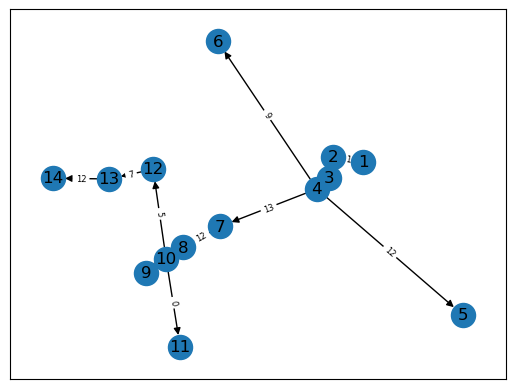

In [7]:
# Création d'un sous-graphe à partir du graphe original
selected_nodes = [i for i in range(1,15)]

G = G.subgraph(selected_nodes)

pos = nx.spring_layout(G)  # Layout pour une meilleure visualisation
labels = nx.get_edge_attributes(G, 'edge_type')

# Définition de la taille de la police pour les étiquettes des arêtes
edge_labels_font = {'font_size': 6}

nx.draw_networkx_nodes(G, pos)
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edges(G, pos, arrows=True)
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=edge_labels_font['font_size'])
plt.show()

In [8]:
def in_out_count(graph):
    X = np.empty((len(graph.nodes()),2 * N_vocab_links))
    for node in graph.nodes():
        i = node - 1
        x = np.zeros(2 * N_vocab_links)
        arcs_entrants = G.in_edges(node, data=True)
        arcs_sortants = G.out_edges(node, data=True)
        for source, target, data in arcs_entrants:
            edge_type = data['edge_type']
            x[edge_type] += 1
        for source, target, data in arcs_sortants:
            edge_type = data['edge_type']
            x[N_vocab_links + edge_type] += 1
        X[i,:] = x
    return X

In [9]:
L_X = []
L_y = []
for id in training_set:
    G = get_transcript_and_graph(id)[1]
    L_X.append(in_out_count(G))
    L_y.append(np.array(get_labels(id)))
X = np.concatenate(L_X)
y = np.concatenate(L_y)

In [10]:
from tensorflow.keras import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Embedding, Dropout, GRU, RNN, Bidirectional
from sklearn.metrics import accuracy_score, f1_score,confusion_matrix


2023-11-18 13:44:09.633777: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = Sequential()
model.add(Embedding(input_dim=len(X_test)+1, output_dim=200)) 
model.add(Bidirectional(GRU(256, return_sequences=True))) 
model.add(Dropout(0.3))  
model.add(Dense(256, activation='softmax'))
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 200)         2905200   
                                                                 
 bidirectional (Bidirection  (None, None, 512)         703488    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, None, 512)         0         
                                                                 
 dense (Dense)               (None, None, 256)         131328    
                                                                 
Total params: 3740016 (14.27 MB)
Trainable params: 3740016 (14.27 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [12]:
predictions = model.predict(X_test)
predictions_labels = np.argmax(predictions, axis=-1)

print('f1:', f1_score(y_test, predictions_labels, average='weighted'))
accuracy = accuracy_score(y_test, predictions_labels)
print(f"Précision du classificateur aléatoire : {accuracy}")

454/454 [==============================] - 11s 23ms/step


ValueError: Classification metrics can't handle a mix of binary and multiclass-multioutput targets

In [13]:
test_labels = {}
for transcription_id in test_set:
    G = get_transcript_and_graph(transcription_id, path=path_to_test)[1]
    X_test = in_out_count(G)

    y_test = model.predict(X_test)
    y_test= np.argmax(y_test, axis=-1)
    print(y_test)
    test_labels[transcription_id] = y_test.tolist()

with open("test_labels_essai.json", "w") as file:
    json.dump(test_labels, file, indent=4)


10/10 [==============================] - 0s 19ms/step
[[ 75  75 188 ... 188 188 188]
 [ 75  75 188 ... 216 216 188]
 [ 75  75 188 ... 188 188 188]
 ...
 [ 75  75 188 ... 216 216 188]
 [ 75  75 188 ... 188 188 188]
 [ 75  75 188 ... 188 188 188]]
24/24 [==============================] - 0s 20ms/step
[[ 75  75 188 ... 216 216 216]
 [ 75  75 188 ... 188 188 188]
 [ 75  75 188 ... 188 188 188]
 ...
 [ 61 216 216 ... 188 188 188]
 [ 61 216 216 ... 188 188 188]
 [ 75  75 188 ... 216 188 188]]
24/24 [==============================] - 1s 23ms/step
[[216 132 216 ... 188 188 188]
 [ 75  75 188 ... 216 216 188]
 [ 75  75 188 ... 216 216 188]
 ...
 [ 75  75 188 ... 188 188 188]
 [ 61 216 216 ... 188 188 188]
 [ 75  75 188 ... 216 216 188]]
29/29 [==============================] - 1s 20ms/step
[[ 75  75 188 ... 188 188 188]
 [216 132 216 ... 216 216 216]
 [216 132 216 ... 188 188 188]
 ...
 [ 75  75 188 ... 188 188 188]
 [ 75  75 188 ... 188 188 188]
 [ 75  75 188 ... 216 216 188]]
14/14 [=========

In [14]:
predictions = model.predict(X_test)

46/46 [==============================] - 1s 27ms/step


In [15]:
import numpy as np
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, GRU, Dropout, Dense

# Assuming you have X and y defined before this code snippet

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = Sequential()
model.add(Embedding(input_dim=len(X_test) + 1, output_dim=200))
model.add(Bidirectional(GRU(256, return_sequences=True)))
model.add(Dropout(0.3))
model.add(Dense(256, activation='softmax'))
model.summary()

# Compile and train your model here

predictions = model.predict(X_test)
predictions_labels = np.argmax(predictions, axis=-1)

# Diagnose the issue
print(np.unique(y_test))
print(np.unique(predictions_labels))
print(y_test.shape, predictions_labels.shape)

# Calculate metrics
print('f1:', f1_score(y_test, predictions_labels, average='samples'))
accuracy = accuracy_score(y_test, predictions_labels)
print(f"Précision du classificateur aléatoire : {accuracy}")


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 200)         2905200   
                                                                 
 bidirectional_1 (Bidirecti  (None, None, 512)         703488    
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, None, 512)         0         
                                                                 
 dense_1 (Dense)             (None, None, 256)         131328    
                                                                 
Total params: 3740016 (14.27 MB)
Trainable params: 3740016 (14.27 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
454/454 [==============================] - 10s 21ms/step
[0 1]
[  2  17  20  25 

ValueError: Classification metrics can't handle a mix of binary and multiclass-multioutput targets